## Gaussian Process Classification

# Packages, sklearn

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, RationalQuadratic, Matern, ConstantKernel 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import OneHotEncoder
from matplotlib.ticker import FormatStrFormatter

# Suppress all ConvergenceWarnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Retriving and processing the data

In [208]:
#choose a seed.
seed = 2
np.random.seed(seed)

# Import some data to play with.
digits = datasets.load_digits()

X_data = digits.data
y_data = np.array(digits.target, dtype = int)
original_indices = np.arange(len(y))  # Track original indices
X, y, original_indices = shuffle(X_data, y_data, original_indices)  # Shuffle all
N,d = X.shape

# Part a - Gaussian Process classification (sklearn - several OvR classifiers)

In [209]:
N = np.int64(600)
Ntrain = np.int64(500)
Ntest = np.int64(100)

Xtrain = X[0:Ntrain-1,:]
ytrain = y[0:Ntrain-1]
Xtest = X[Ntrain:N,:]
ytest = y[Ntrain:N]

kernels = { # Have to pre-define bounds otherwise, sklearn built in optimzier drives the variance to zero.
    "RBF": ConstantKernel (1.0, (1e-2, 1e2)) * RBF(length_scale=10.0, length_scale_bounds=(1e-2, 1e2)),
    "DotProduct": DotProduct(sigma_0=10.0),
    "Matern": ConstantKernel(1.0, (1e1, 1e3)) * Matern(length_scale=1.0, nu=1),
    "RationalQuadratic": RationalQuadratic(),
}

misclassified_samples = {
    "train": {},
    "test": {}
}

yp_tests = {}

for kernel_name, kernel in kernels.items():
    print(f"Testing kernel: {kernel_name}")
    gpc = GaussianProcessClassifier(kernel=kernel)  # GaussianProcessClassifier also optimaizes the hyper parameters.
    gpc.fit(Xtrain, ytrain)
    
    # Predictions.
    yp_train = gpc.predict(Xtrain)
    train_error_rate = np.mean(np.not_equal(yp_train, ytrain))
    yp_test = gpc.predict(Xtest)
    test_error_rate = np.mean(np.not_equal(yp_test, ytest))
    yp_tests[kernel_name] = yp_test

    # Print results.
    print(f"Training error rate for {kernel_name}: {train_error_rate}")
    print(f"Test error rate for {kernel_name}: {test_error_rate}")
    print("Optimized kernel:", gpc.kernel_, "\n")

    # Find misclassified samples and save them.
    misclassified_train_indices = np.where(yp_train != ytrain)[0].tolist()
    misclassified_test_indices = np.where(yp_test != ytest)[0].tolist()
    misclassified_samples["train"][kernel_name] = misclassified_train_indices
    misclassified_samples["test"][kernel_name] = misclassified_test_indices

Testing kernel: RBF
Training error rate for RBF: 0.0
Test error rate for RBF: 0.03
Optimized kernel: CompoundKernel(4.61, 4.02, 4.61, 3.74, 4.61, 4.03, 4.61, 3.9, 4.61, 3.91, 4.61, 4.06, 4.61, 3.94, 4.61, 3.97, 4.61, 3.84, 4.61, 3.91) 

Testing kernel: DotProduct
Training error rate for DotProduct: 0.0
Test error rate for DotProduct: 0.08
Optimized kernel: CompoundKernel(2.67, 3.79, 3.73, -1.3, -2.86, 3.89, 3.74, 3.57, 4, 3.99) 

Testing kernel: Matern
Training error rate for Matern: 0.0
Test error rate for Matern: 0.02
Optimized kernel: CompoundKernel(2.3, 0.000284, 2.3, 0.000284, 2.3, 0.000284, 2.3, 0.000284, 2.3, 0.000284, 2.3, 0.000284, 2.3, 0.000284, 2.3, 0.000284, 2.3, 0.000284, 2.3, 0.000284) 

Testing kernel: RationalQuadratic
Training error rate for RationalQuadratic: 0.036072144288577156
Test error rate for RationalQuadratic: 0.06
Optimized kernel: CompoundKernel(11.5, 3.6, 11.5, 3.51, 11.5, 3.58, 11.5, 3.57, 11.5, 3.58, 11.5, 3.58, 11.5, 3.59, 11.5, 3.59, 0.726, 3.54, 11.5, 

# Plotting the missclassifications

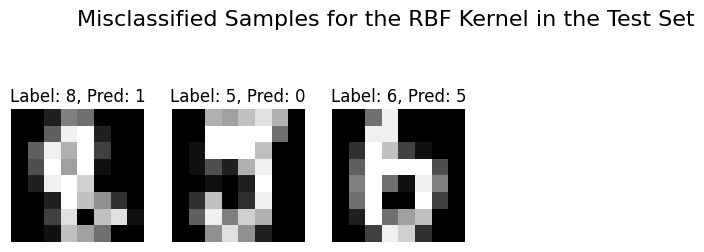

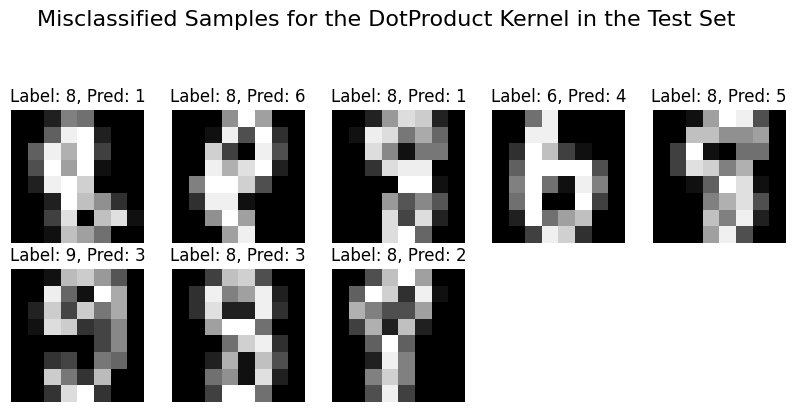

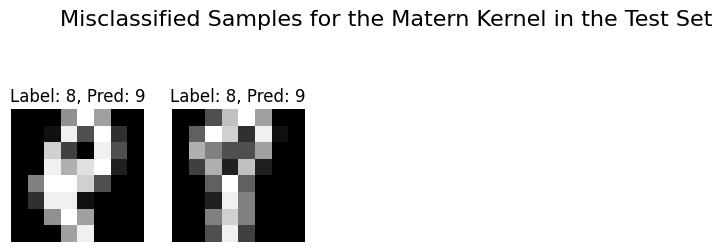

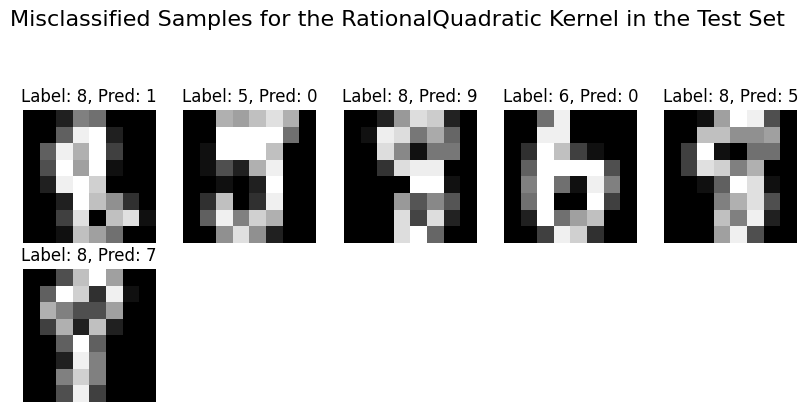

In [210]:
def plot_misclassified_samples(kernel_name, misclassified_samples, original_indices, yp_test, y_data, Ntrain):
    # Get the misclassified global indices
    misclassified_indices_global = [original_indices[Ntrain + idx] for idx in misclassified_samples["test"][kernel_name]]

    # Plot misclassified test images
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(misclassified_indices_global):
        plt.subplot(5, 5, i + 1)  # Adjust 5,5 for the number of images to display
        plt.imshow(digits.images[idx], cmap='gray')
        plt.title(f"Label: {y_data[idx]}, Pred: {yp_test[kernel_name][misclassified_samples['test'][kernel_name][i]]}")
        plt.axis('off')
    
    plt.suptitle(f"Misclassified Samples for the {kernel_name} Kernel in the Test Set", fontsize=16)
    plt.show()

# Plot for all kernels
for kernel_name, kernel in kernels.items():
    plot_misclassified_samples(kernel_name, misclassified_samples, original_indices, yp_tests, y_data, Ntrain)

# Plotting the Errors  

(50, 64)
(100, 64)
(150, 64)
(200, 64)
(250, 64)
(300, 64)
(350, 64)
(400, 64)
(450, 64)
(500, 64)
(550, 64)
(600, 64)


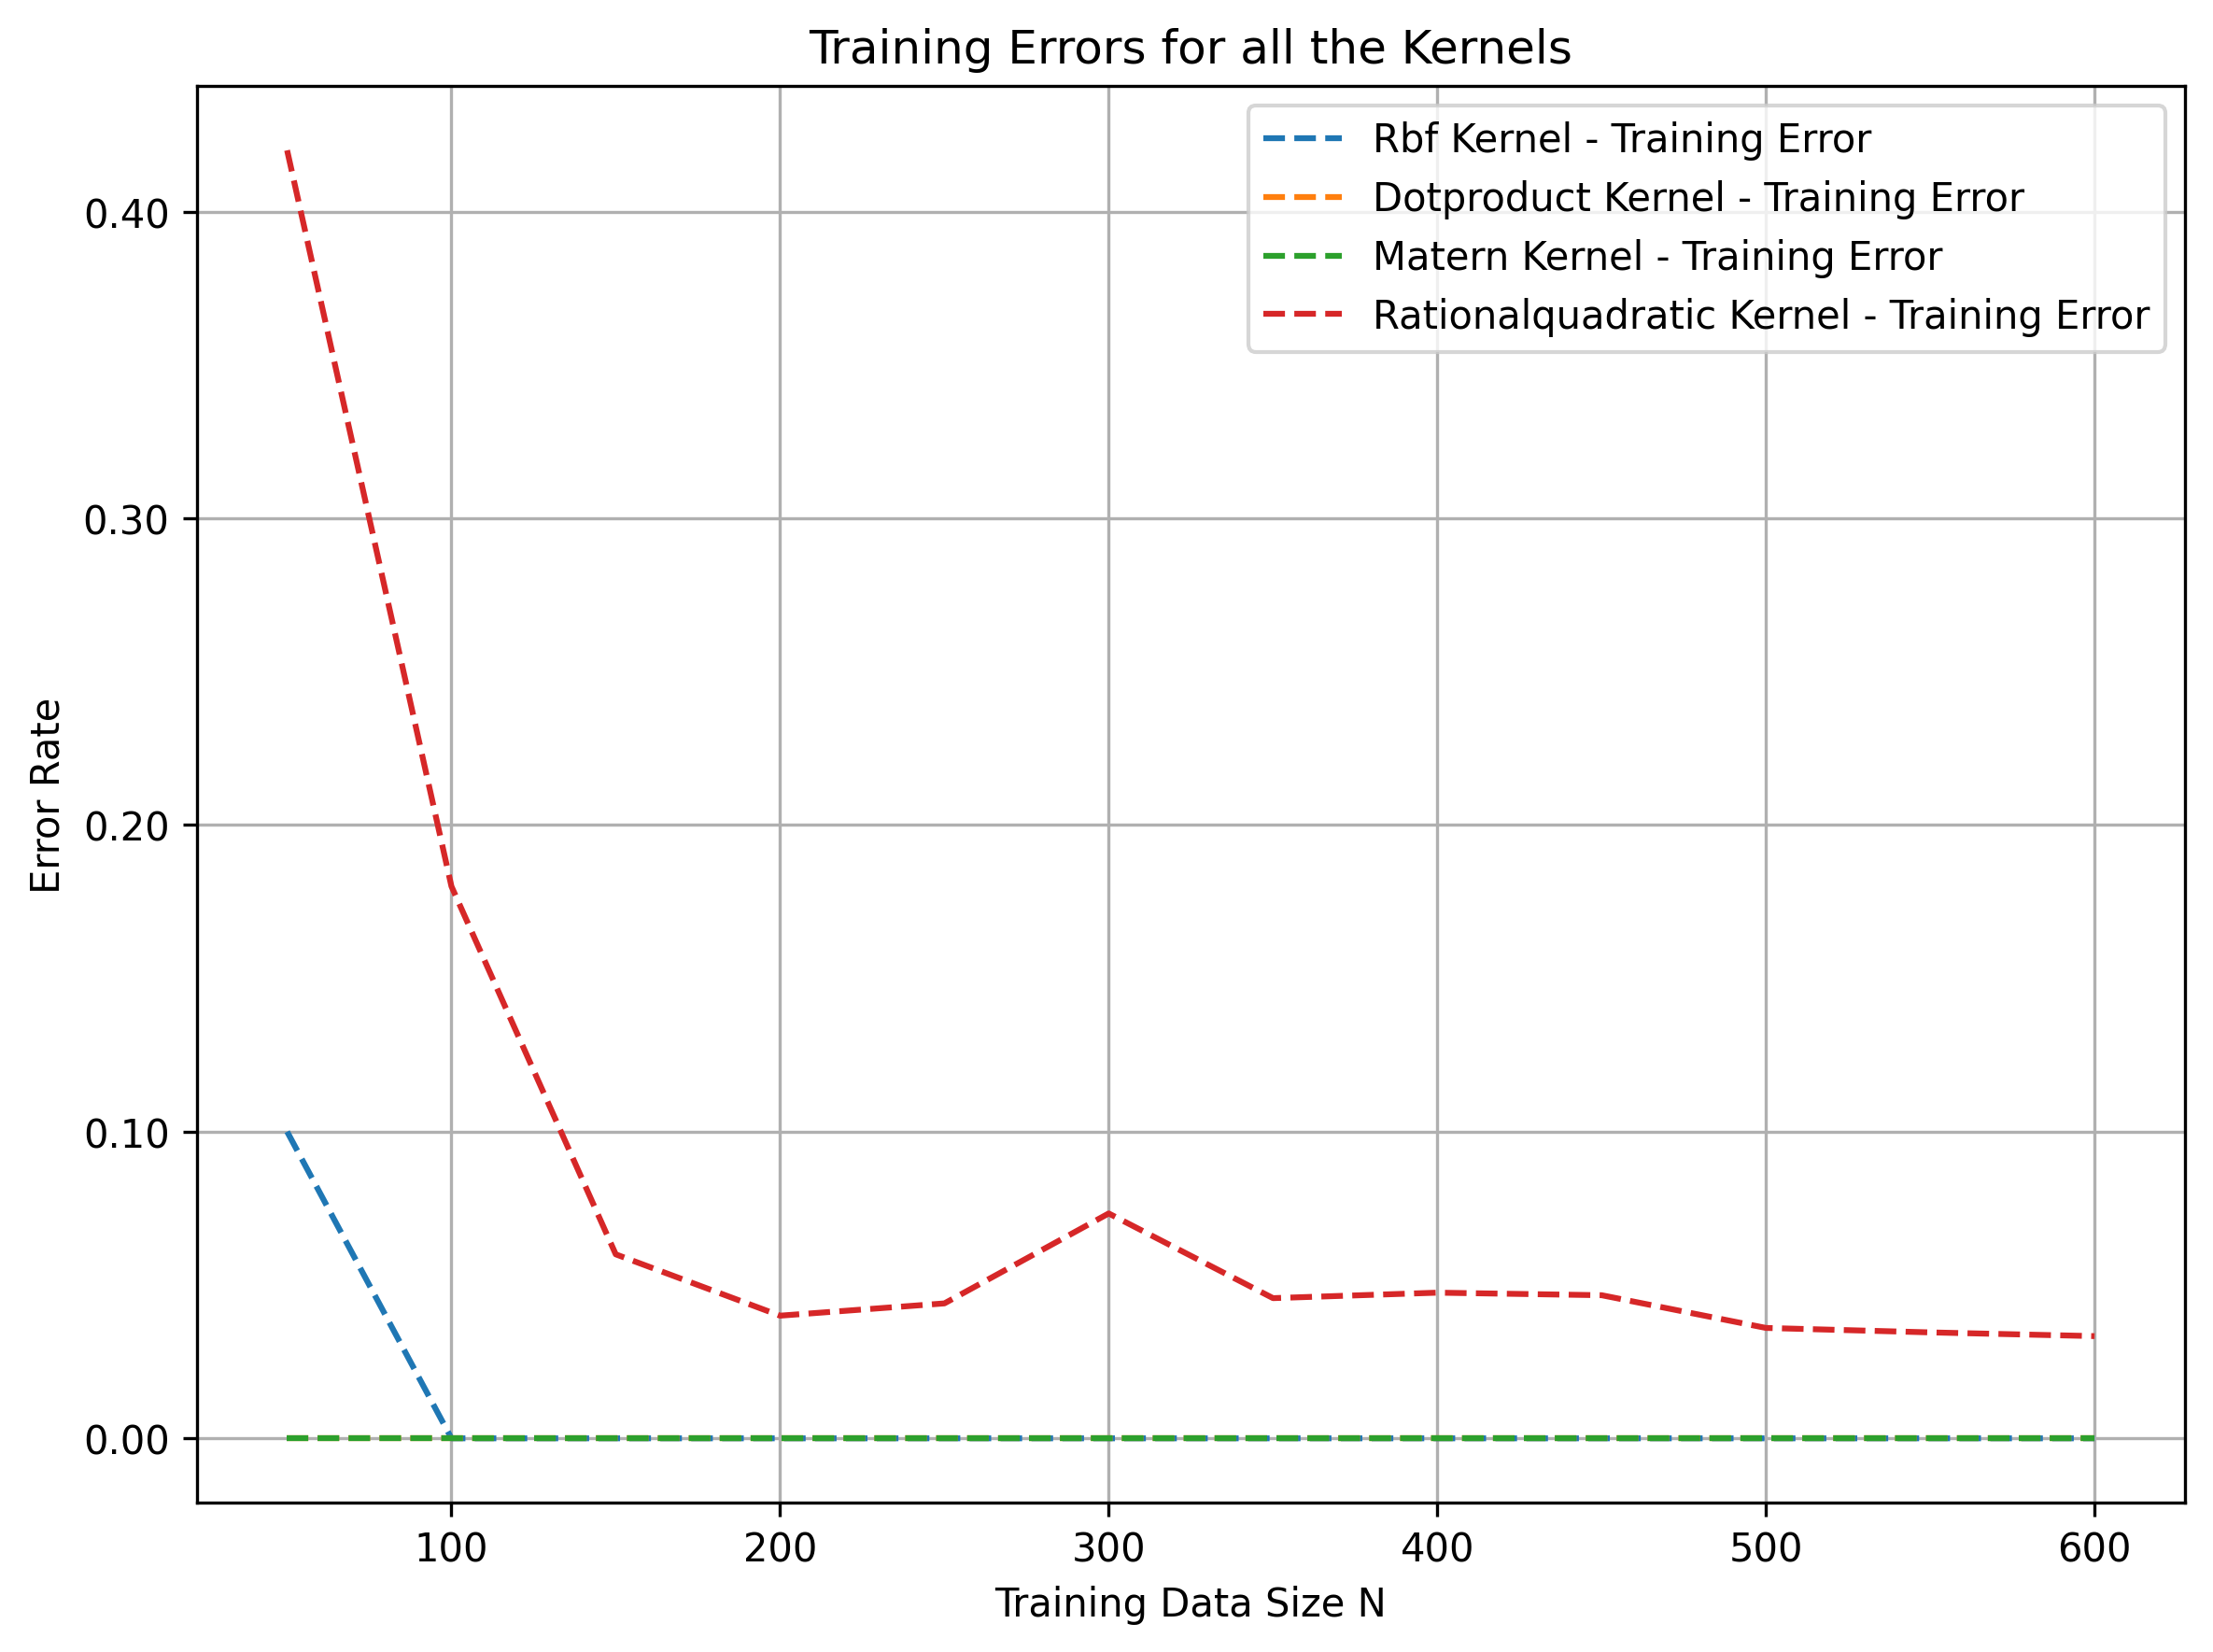

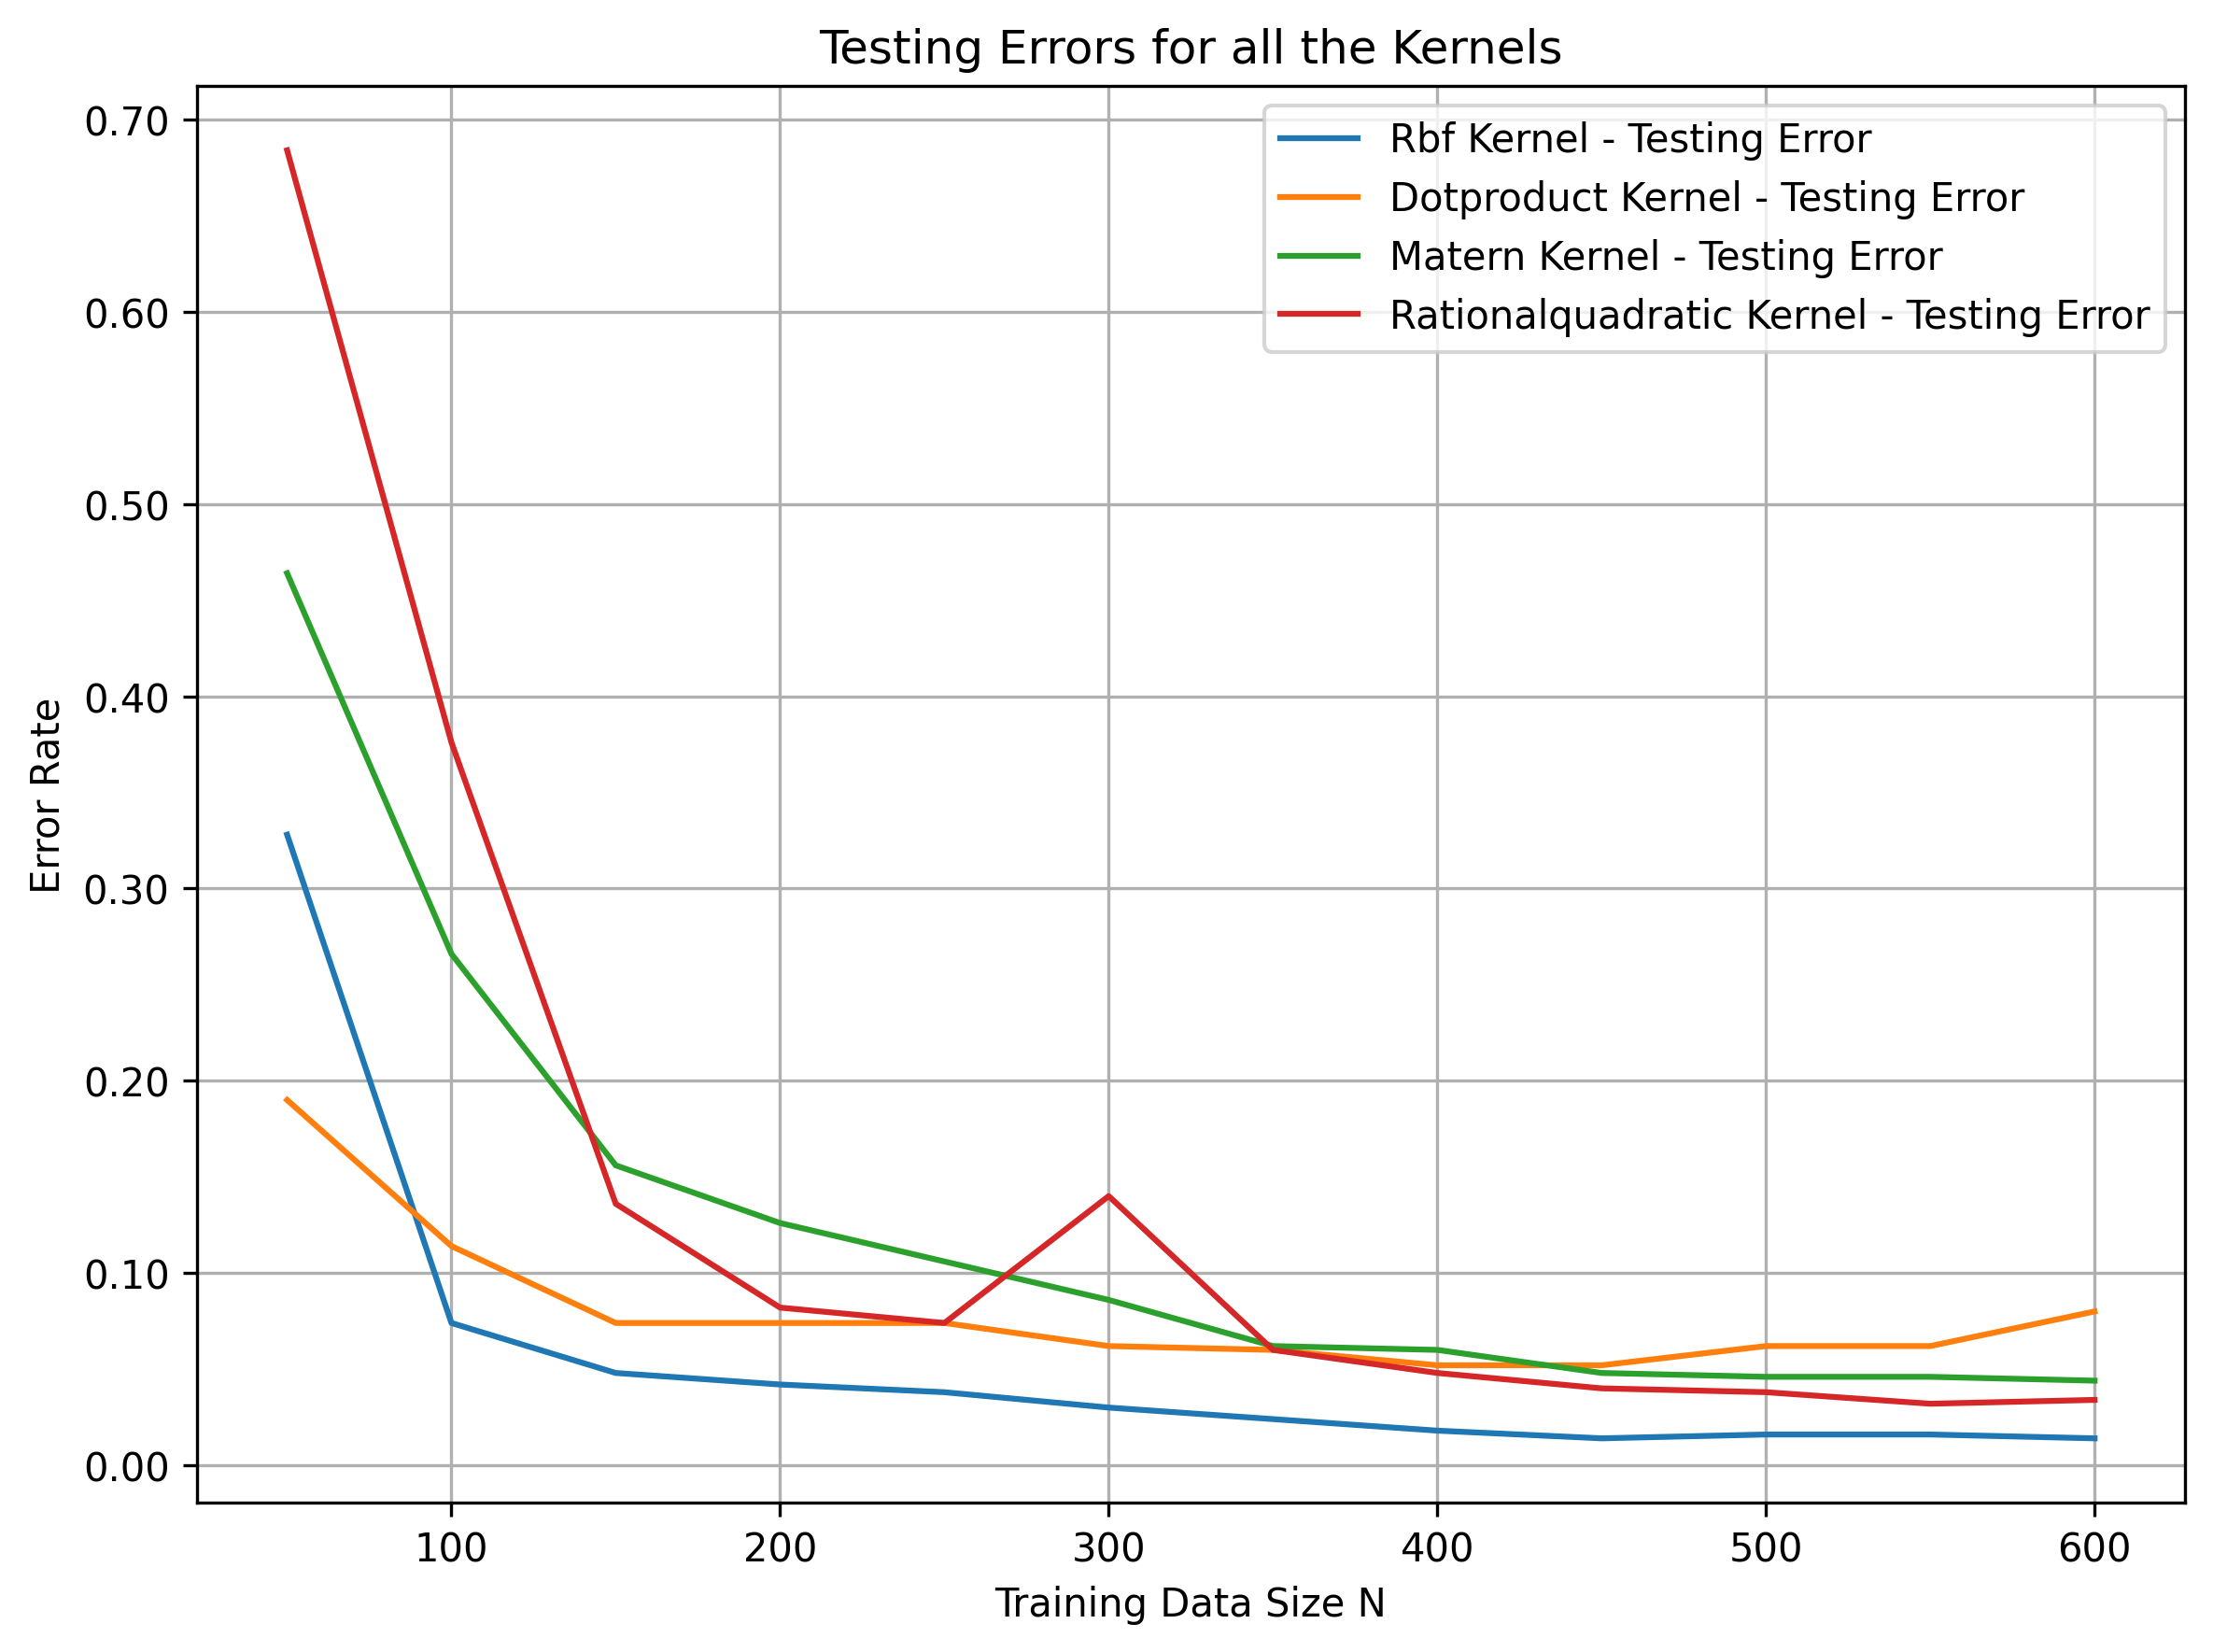

In [212]:
N, d = X_data.shape

Ntrain = 601 # More trading data.

train_sizes = np.arange(50, Ntrain, 50)
training_errors = {kernel: [] for kernel in kernels}
testing_errors = {kernel: [] for kernel in kernels}

Xtrain = X[0:Ntrain-1,:]
ytrain = y[0:Ntrain-1]
# Uses last 500 samples as test.
Xtest = X[N-500:N,:]
ytest = y[N-500:N]

# Loop over train sizes and kernels.
for train_size in train_sizes:
    X_subtrain = Xtrain[:train_size]
    print(X_subtrain.shape) # Shows the progress.
    y_subtrain = ytrain[:train_size]
    for kernel_name, kernel in kernels.items():
        gpc = GaussianProcessClassifier(kernel=kernel)
        gpc.fit(X_subtrain, y_subtrain)
        
        # Train error.
        yp_train = gpc.predict(X_subtrain)
        train_error_rate = np.mean(np.not_equal(yp_train, y_subtrain))
        training_errors[kernel_name].append(train_error_rate)
        
        # Test error.
        yp_test = gpc.predict(Xtest)
        test_error_rate = np.mean(np.not_equal(yp_test, ytest))
        testing_errors[kernel_name].append(test_error_rate)

fig_size = (8, 6)
plt.figure(figsize=fig_size, dpi=300)
for kernel_name in kernels:
    plt.plot(train_sizes, training_errors[kernel_name], label=f"{kernel_name.capitalize()} Kernel - Training Error", linestyle="--")
plt.title("Training Errors for all the Kernels")
plt.xlabel("Training Data Size N")
plt.ylabel("Error Rate")
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Set 2 decimal places for y-axis
plt.tight_layout()

plt.figure(figsize=fig_size, dpi=300)
for kernel_name in kernels:
    plt.plot(train_sizes, testing_errors[kernel_name], label=f"{kernel_name.capitalize()} Kernel - Testing Error", linestyle="-")
plt.title("Testing Errors for all the Kernels")
plt.xlabel("Training Data Size N")
plt.ylabel("Error Rate")
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Set 2 decimal places for y-axis
plt.tight_layout()

plt.show()

# Part b - Classification using Gaussian Process regressor

In [193]:
N = np.int64(600)
Ntrain = np.int64(500)
Ntest = np.int64(100)

Xtrain = X[0:Ntrain,:]
ytrain = y[0:Ntrain]
Xtest = X[Ntrain:N,:]
ytest = y[Ntrain:N]

kernels = { # Works better not predefining bounds.
    "RBF": RBF(),
    "DotProduct": DotProduct(),
    "Matern": Matern(),
    "RationalQuadratic": RationalQuadratic()
}

misclassified_samples = {
    "train": {},
    "test": {}
}

yp_tests = {}

# One-hot encode the labels.
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot_train = onehot_encoder.fit_transform(ytrain.reshape(-1, 1))
y_onehot_test = onehot_encoder.transform(ytest.reshape(-1, 1))

for kernel_name, kernel in kernels.items():
    print(f"Evaluating kernel: {kernel_name}")
    
    # Train one GP regressor for each output dimension 0-9.
    gprs = [GaussianProcessRegressor(kernel=kernel, random_state=seed).fit(Xtrain, y_onehot_train[:, i]) for i in range(y_onehot_train.shape[1])]
    
    yp_train_one_hot = np.column_stack([gpr.predict(Xtrain) for gpr in gprs])
    yp_train = np.argmax(yp_train_one_hot, axis=1)
    yp_test_one_hot = np.column_stack([gpr.predict(Xtest) for gpr in gprs])
    yp_test = np.argmax(yp_test_one_hot, axis=1)
    yp_tests[kernel_name] = yp_test

    # Predictions.
    train_error_rate = np.mean(np.not_equal(yp_train, ytrain))
    test_error_rate = np.mean(np.not_equal(yp_test, ytest))
    
    print(f"Training error rate for {kernel_name}: {train_error_rate}")
    print(f"Test error rate for {kernel_name}: {test_error_rate}")

    # Find misclassified samples and save them.
    misclassified_train_indices = np.where(yp_train != ytrain)[0].tolist()
    misclassified_test_indices = np.where(yp_test != ytest)[0].tolist()
    misclassified_samples["train"][kernel_name] = misclassified_train_indices
    misclassified_samples["test"][kernel_name] = misclassified_test_indices


Evaluating kernel: RBF
Training error rate for RBF: 0.0
Test error rate for RBF: 0.01
Evaluating kernel: DotProduct
Training error rate for DotProduct: 0.048
Test error rate for DotProduct: 0.11
Evaluating kernel: Matern
Training error rate for Matern: 0.0
Test error rate for Matern: 0.01
Evaluating kernel: RationalQuadratic
Training error rate for RationalQuadratic: 0.0
Test error rate for RationalQuadratic: 0.02


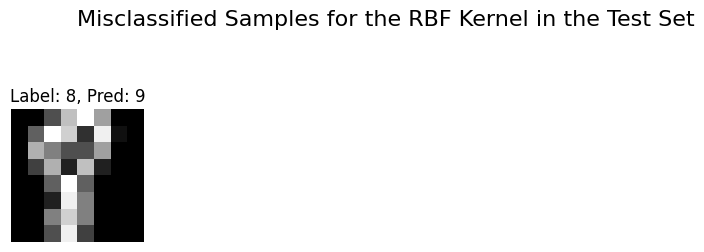

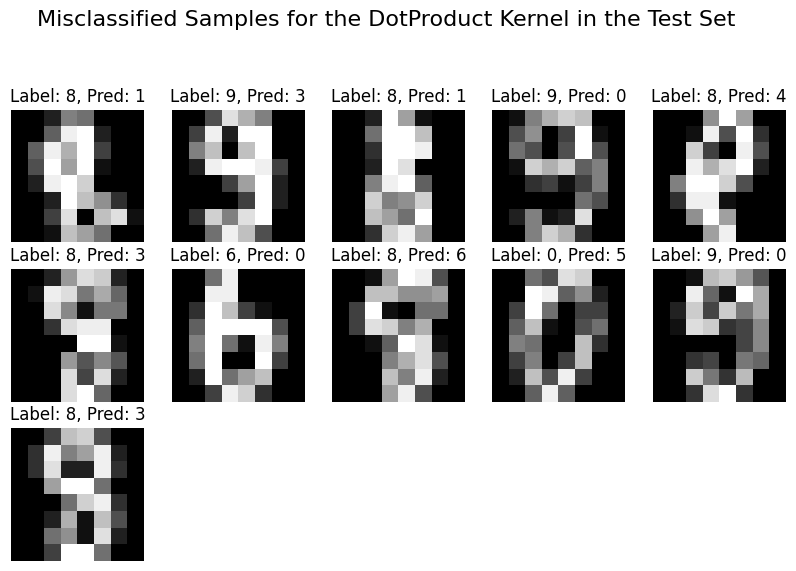

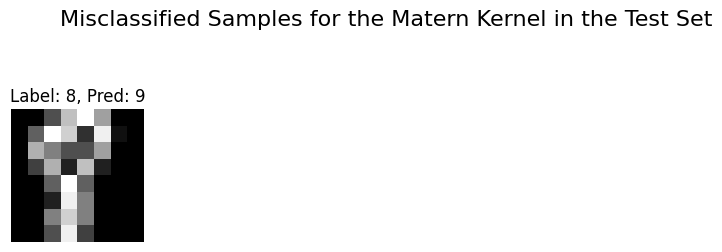

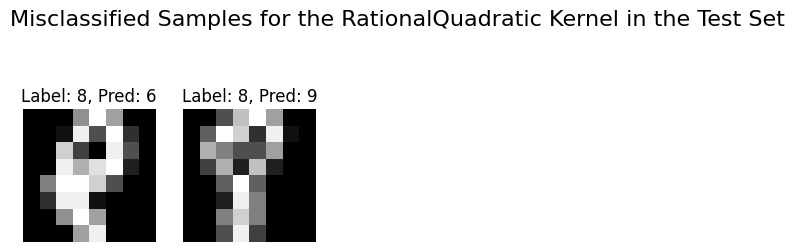

In [194]:
def plot_misclassified_samples(kernel_name, misclassified_samples, original_indices, yp_test, y_data, Ntrain):
    # Get the misclassified global indices
    misclassified_indices_global = [original_indices[Ntrain + idx] for idx in misclassified_samples["test"][kernel_name]]

    # Plot misclassified test images
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(misclassified_indices_global):
        plt.subplot(5, 5, i + 1)  # Adjust 5,5 for the number of images to display
        plt.imshow(digits.images[idx], cmap='gray')
        plt.title(f"Label: {y_data[idx]}, Pred: {yp_test[kernel_name][misclassified_samples['test'][kernel_name][i]]}")
        plt.axis('off')
    
    plt.suptitle(f"Misclassified Samples for the {kernel_name} Kernel in the Test Set", fontsize=16)
    plt.show()

# Plot for all kernels
for kernel_name, kernel in kernels.items():
    plot_misclassified_samples(kernel_name, misclassified_samples, original_indices, yp_tests, y_data, Ntrain)

# Plotting the Errors

(50, 64)
(100, 64)
(150, 64)
(200, 64)
(250, 64)
(300, 64)
(350, 64)
(400, 64)
(450, 64)
(500, 64)
(550, 64)
(600, 64)


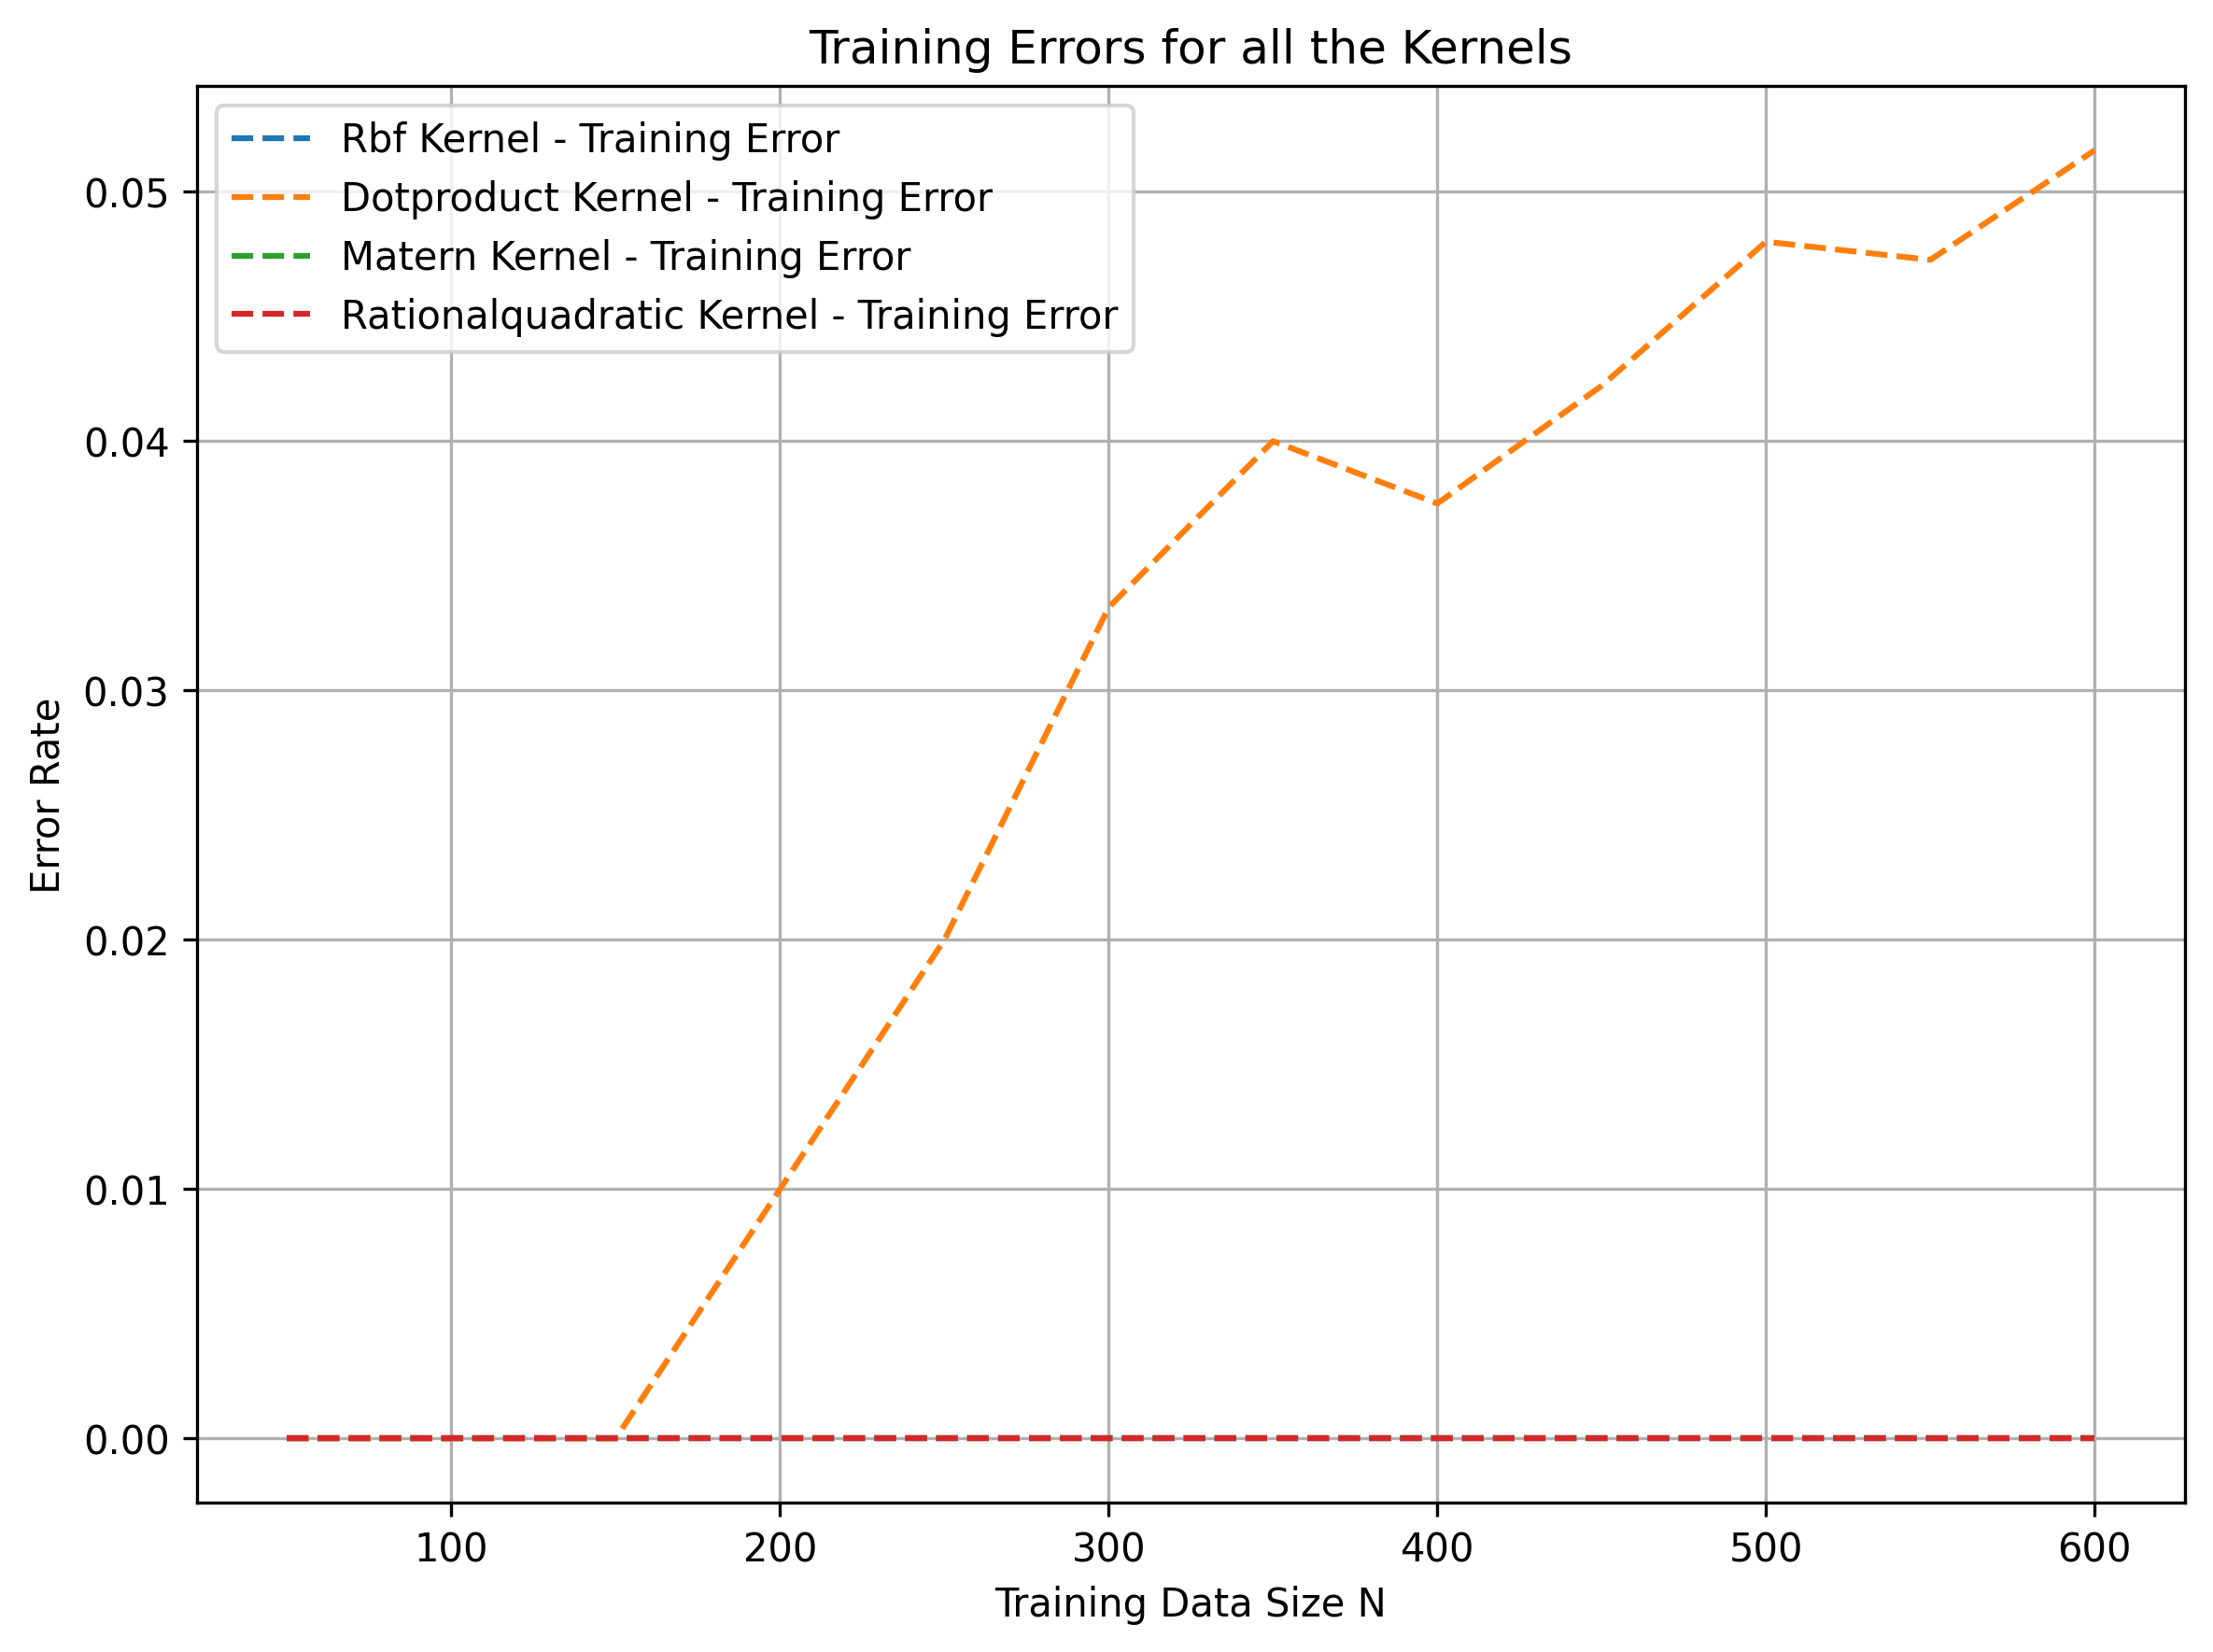

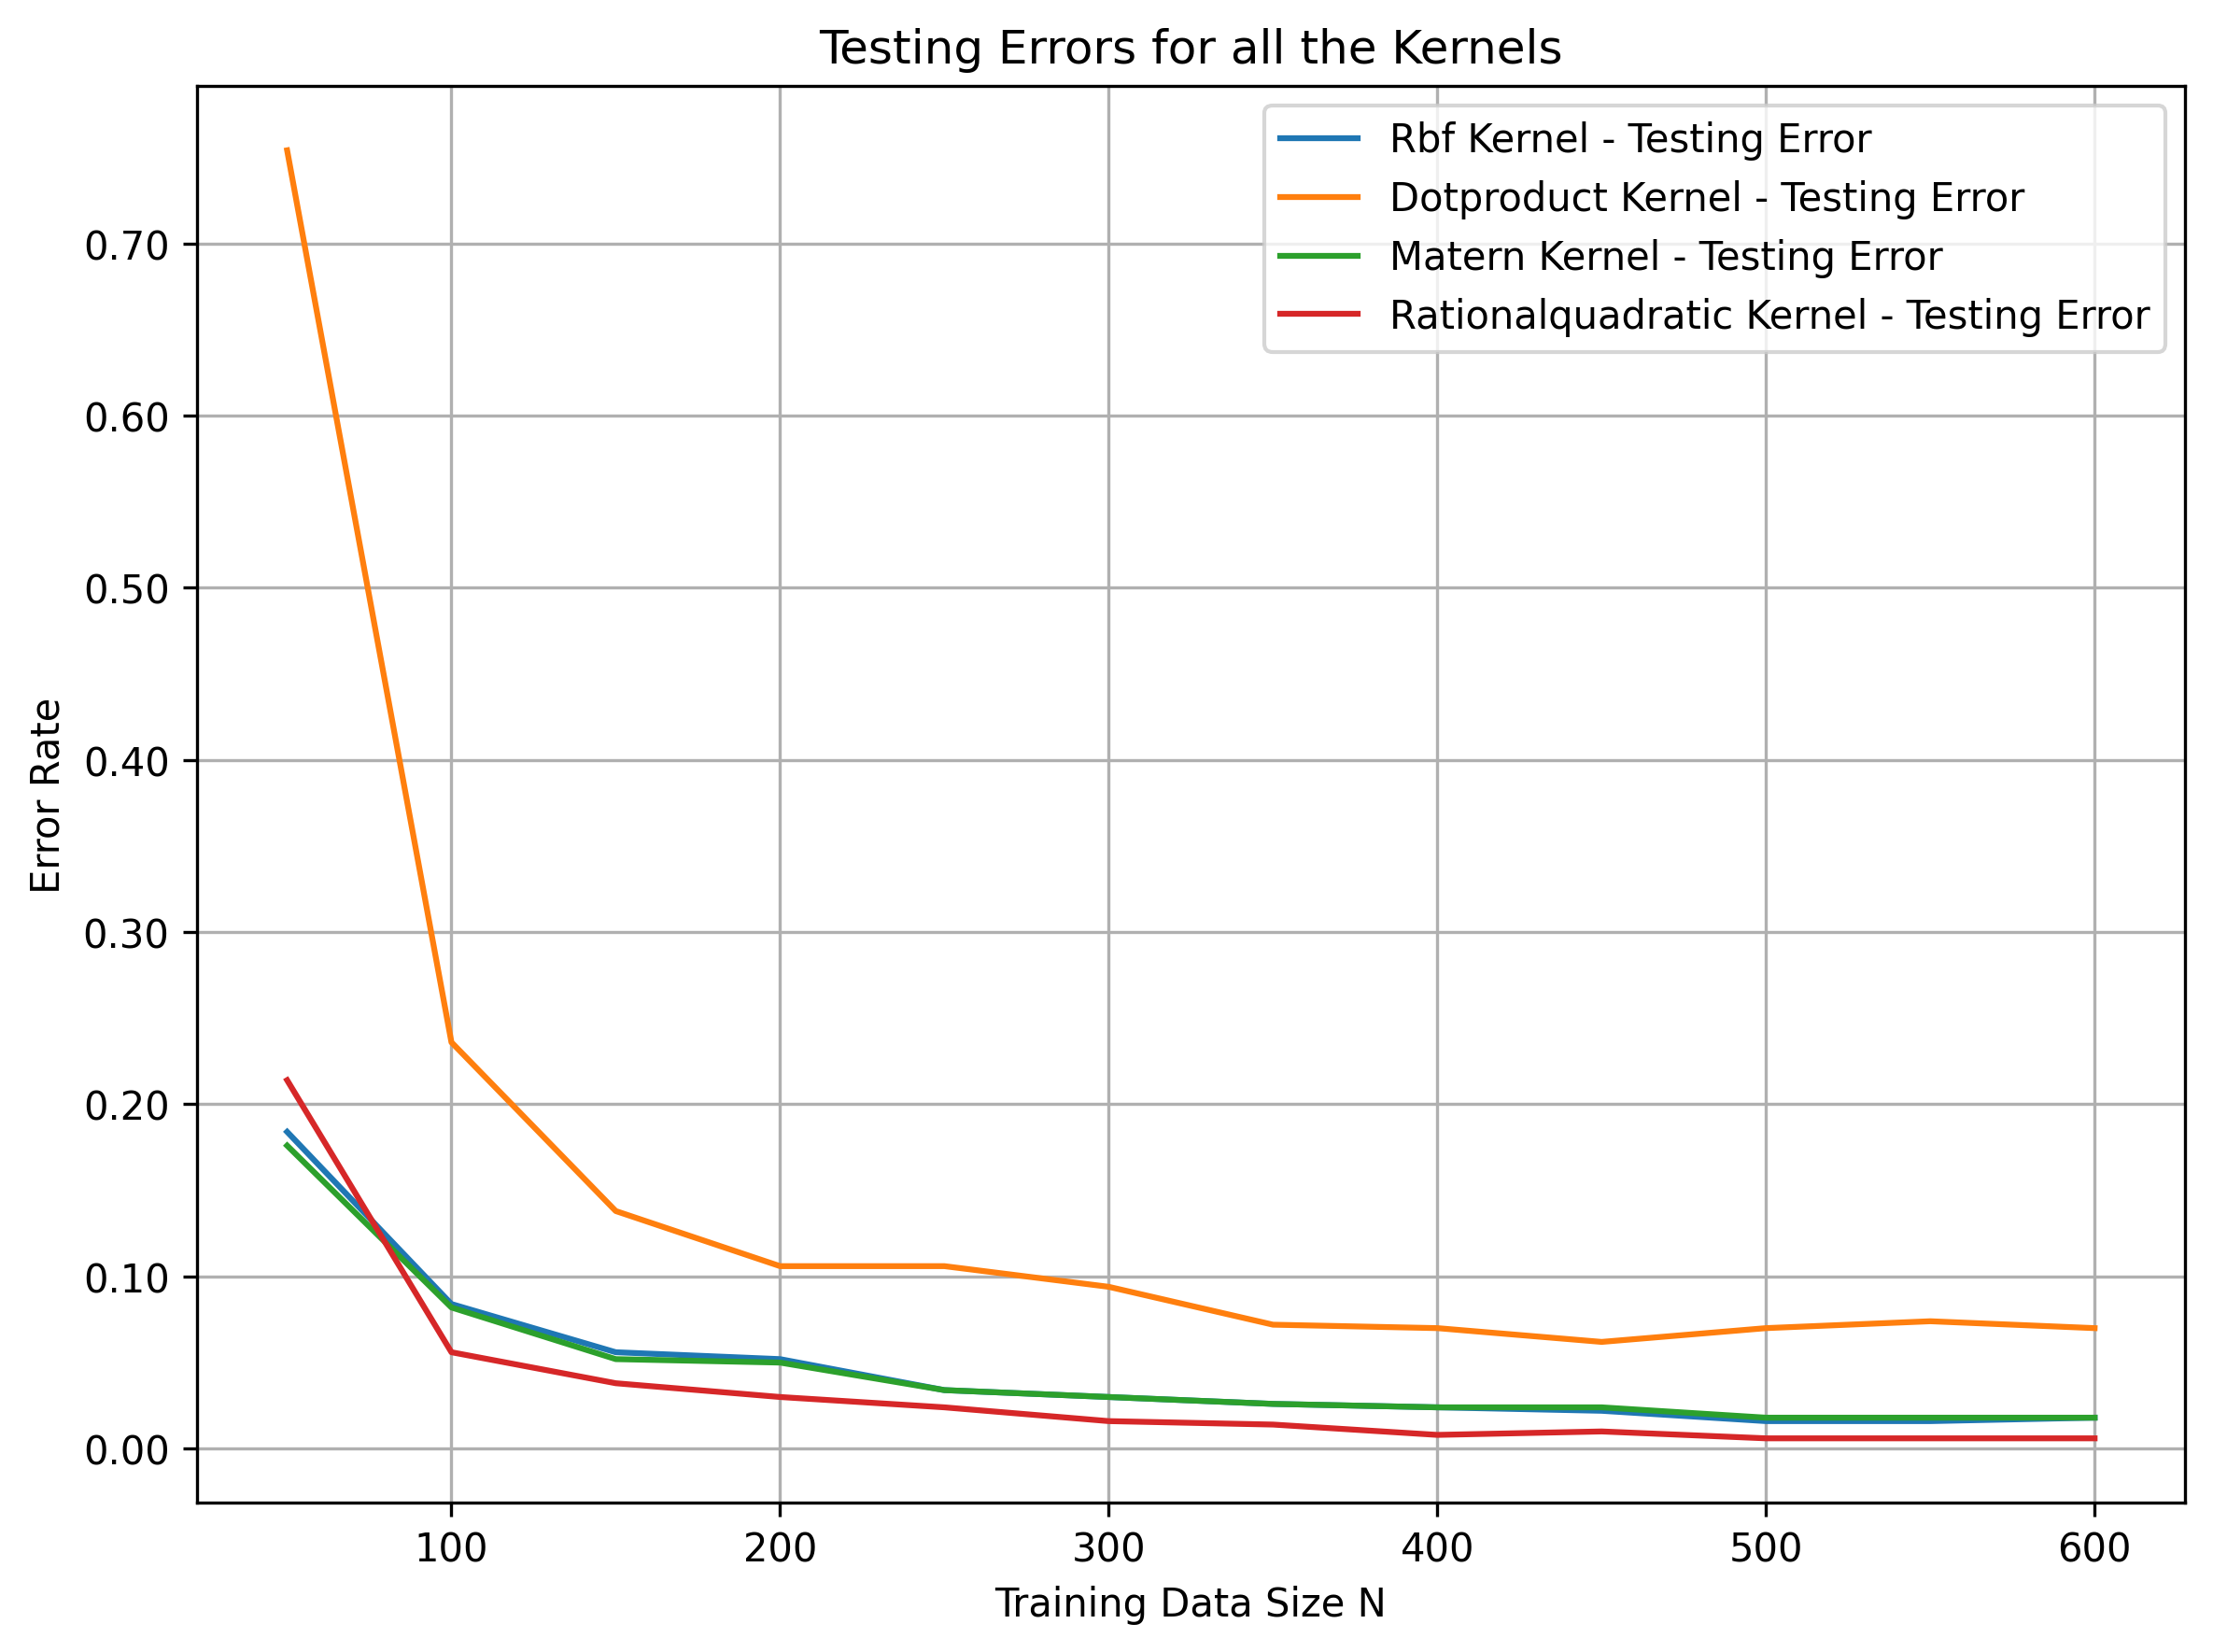

In [203]:
N, d = X_data.shape

Ntrain = 601 # More trading data.

train_sizes = np.arange(50, Ntrain, 50)
training_errors = {kernel: [] for kernel in kernels}
testing_errors = {kernel: [] for kernel in kernels}

Xtrain = X[0:Ntrain-1,:]
ytrain = y[0:Ntrain-1]
# Uses last 500 samples as test.
Xtest = X[N-500:N,:]
ytest = y[N-500:N]

# One-hot encode the labels.
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot_train = onehot_encoder.fit_transform(ytrain.reshape(-1, 1))
y_onehot_test = onehot_encoder.transform(ytest.reshape(-1, 1))

# Loop over train sizes and kernels.
for train_size in train_sizes:
    X_subtrain = Xtrain[:train_size]
    print(X_subtrain.shape) # Shows the progress.
    y_onehot_subtrain = y_onehot_train[:train_size]
    y_subtrain = ytrain[:train_size]

    for kernel_name, kernel in kernels.items():
        # Train one GP regressor for each output dimension 0-9.
        gprs = [GaussianProcessRegressor(kernel=kernel, random_state=seed).fit(X_subtrain, y_onehot_subtrain[:, i]) for i in range(y_onehot_subtrain.shape[1])]
        
        yp_train_one_hot = np.column_stack([gpr.predict(X_subtrain) for gpr in gprs])
        yp_train = np.argmax(yp_train_one_hot, axis=1)
        yp_test_one_hot = np.column_stack([gpr.predict(Xtest) for gpr in gprs])
        yp_test = np.argmax(yp_test_one_hot, axis=1)

        # Predictions.
        train_error_rate = np.mean(np.not_equal(yp_train, y_subtrain))
        training_errors[kernel_name].append(train_error_rate)

        test_error_rate = np.mean(np.not_equal(yp_test, ytest))
        testing_errors[kernel_name].append(test_error_rate)

fig_size = (8, 6)
plt.figure(figsize=fig_size, dpi=300)
for kernel_name in kernels:
    plt.plot(train_sizes, training_errors[kernel_name], label=f"{kernel_name.capitalize()} Kernel - Training Error", linestyle="--")
plt.title("Training Errors for all the Kernels")
plt.xlabel("Training Data Size N")
plt.ylabel("Error Rate")
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Set 2 decimal places for y-axis
plt.tight_layout()

plt.figure(figsize=fig_size, dpi=300)
for kernel_name in kernels:
    plt.plot(train_sizes, testing_errors[kernel_name], label=f"{kernel_name.capitalize()} Kernel - Testing Error", linestyle="-")
plt.title("Testing Errors for all the Kernels")
plt.xlabel("Training Data Size N")
plt.ylabel("Error Rate")
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Set 2 decimal places for y-axis
plt.tight_layout()

plt.show()